In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
import time
import json
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import os
import torch
import torch.nn as nn
import pandas as pd

In [2]:
class Policy(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=32, output_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


In [71]:
def load_model_features_and_labels():
    features = []
    labels = []
    root_folders = ["./Policys/0.0-0.1/","./Policys/0.1-0.2/","./Policys/0.2-0.3/"]
    label_file = "CL_list.txt"
    for m in range(3):
        bin = 0.1*m
        label = np.loadtxt(os.path.join(f"./Results/KL_Critical_Value_Check_EXP/{bin:.1f}-{bin+0.1:.1f}/",label_file))
        labels.extend(label)
    for root_folder in root_folders:
        for file_name in os.listdir(root_folder):
            model_path = os.path.join(root_folder, file_name)
            model = torch.load(model_path)
            # model = Policy()  # or Behavioural(), depending on what you saved
            # model.load_state_dict(torch.load(model_path))
            # Flatten all parameters to 1D feature vector
            flat_params = []
            for param in model.parameters():
                flat_params.append(np.array(param.detach().cpu().tolist()).flatten())
            feature_vector = np.concatenate(flat_params)

            features.append(feature_vector)

    return np.array(features), labels


Epoch 01 | Train Loss: 0.0164 | Val Loss: 0.0159
Epoch 02 | Train Loss: 0.0163 | Val Loss: 0.0157
Epoch 03 | Train Loss: 0.0159 | Val Loss: 0.0155
Epoch 04 | Train Loss: 0.0156 | Val Loss: 0.0154
Epoch 05 | Train Loss: 0.0158 | Val Loss: 0.0152
Epoch 06 | Train Loss: 0.0152 | Val Loss: 0.0150
Epoch 07 | Train Loss: 0.0152 | Val Loss: 0.0149
Epoch 08 | Train Loss: 0.0151 | Val Loss: 0.0147
Epoch 09 | Train Loss: 0.0151 | Val Loss: 0.0146
Epoch 10 | Train Loss: 0.0148 | Val Loss: 0.0144
Epoch 11 | Train Loss: 0.0146 | Val Loss: 0.0143
Epoch 12 | Train Loss: 0.0147 | Val Loss: 0.0141
Epoch 13 | Train Loss: 0.0142 | Val Loss: 0.0140
Epoch 14 | Train Loss: 0.0141 | Val Loss: 0.0138
Epoch 15 | Train Loss: 0.0140 | Val Loss: 0.0137
Epoch 16 | Train Loss: 0.0141 | Val Loss: 0.0135
Epoch 17 | Train Loss: 0.0141 | Val Loss: 0.0134
Epoch 18 | Train Loss: 0.0135 | Val Loss: 0.0132
Epoch 19 | Train Loss: 0.0139 | Val Loss: 0.0131
Epoch 20 | Train Loss: 0.0136 | Val Loss: 0.0129
Epoch 21 | Train Los

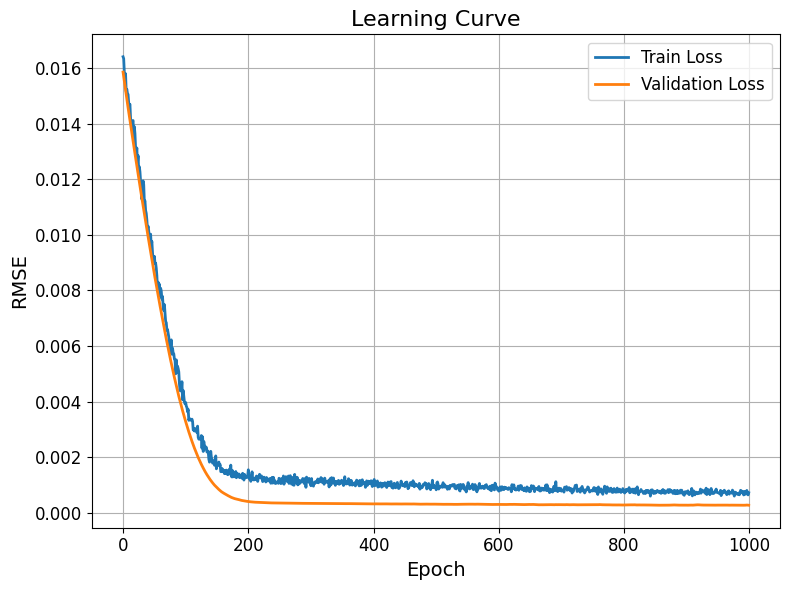


Evaluation Metrics on Validation Set:
MSE  = 0.000200
MAE  = 0.010865
R²   = -0.9431
MAPE = 2.79%


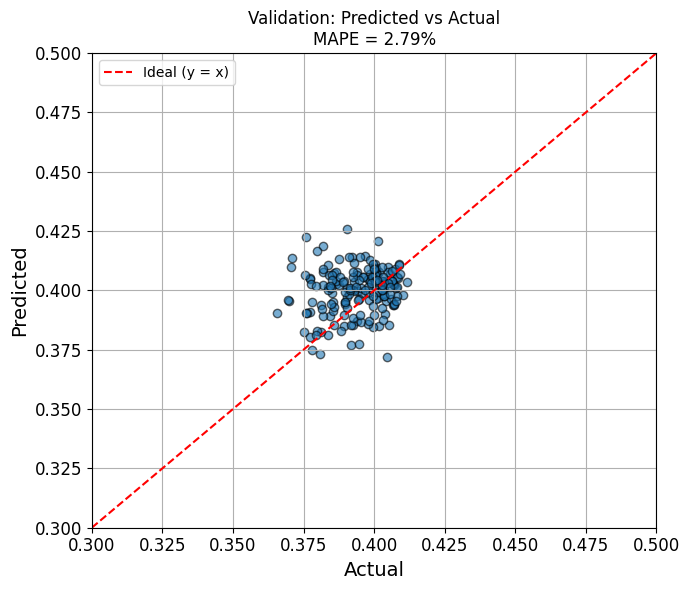

In [128]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Load features and labels ===
X, y = load_model_features_and_labels()  # Make sure this function is defined
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# === Dataset and DataLoader ===
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

# === Model ===
class KLRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# === Custom Weighted MSE Loss ===
def weighted_mse(pred, target):
    weights = 1 + 10 * torch.abs(target - 0.35)  # Focus around 0.3–0.4
    return torch.mean(weights * (pred - target)**2)

# === Train ===
model = KLRegressor(input_dim=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-4)

train_losses = []
val_losses = []

for epoch in range(1000):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = weighted_mse(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            val_loss += weighted_mse(pred, yb).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# === Plot Learning Curve ===
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title('Learning Curve', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# === Evaluation on Validation Set ===
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        pred = model(xb)
        y_true.extend(yb.squeeze().tolist())
        y_pred.extend(pred.squeeze().tolist())

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100

print(f"\nEvaluation Metrics on Validation Set:")
print(f"MSE  = {mse:.6f}")
print(f"MAE  = {mae:.6f}")
print(f"R²   = {r2:.4f}")
print(f"MAPE = {mape:.2f}%")

# === Scatter Plot ===
plt.figure(figsize=(7, 6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
plt.plot([0.3, 0.5], [0.3, 0.5], 'r--', label="Ideal (y = x)")
plt.xlabel("Actual", fontsize=14)
plt.ylabel("Predicted", fontsize=14)
plt.title(f"Validation: Predicted vs Actual\nMAPE = {mape:.2f}%")
plt.xlim(0.3, 0.5)
plt.ylim(0.3, 0.5)
plt.legend()
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Save model weights
torch.save(model.state_dict(), "Hi_CoLA_net.pth")